<a href="https://colab.research.google.com/github/junefish/pinecone-example-colabs/blob/main/hybrid_search_ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hybrid Search for E-Commerce with Pinecone


Hybrid vector search is combination of traditional keyword search and modern dense vector search. It has emerged as a powerful tool for e-commerce companies looking to improve the search experience for their customers.

By combining the strengths of traditional text-based search algorithms with the visual recognition capabilities of deep learning models, hybrid vector search allows users to search for products using a combination of text and images. This can be especially useful for product searches, where customers may not know the exact name or details of the item they are looking for.

Pinecone's new **sparse-dense index** allows you to seamlessly perform hybrid search for e-commerce or in any other context. This notebook demonstrates how to use the new hybrid search feature to improve e-commerce search.

## Install Dependencies

First, let's import the necessary libraries


In [6]:
!pip install -qU datasets transformers sentence-transformers \
                 pinecone-client pinecone-text protobuf==3.20.3

## Connect to Pinecone

Let's initiate a connection and create an index. For this, we need a [free API key](https://app.pinecone.io/), and then we initialize the connection like so:

In [7]:
!pip install python-dotenv
import dotenv

from google.colab import drive
drive.mount('/content/drive')

dotenv.load_dotenv('/content/drive/MyDrive/Colab Notebooks/.env')

import os
import pinecone

# initialize connection to pinecone (get API key at app.pinecone.io)
api_key = os.getenv("PINECONE_API_KEY") or "PINECONE_API_KEY"
# find your environment next to the api key in pinecone console
env = os.getenv("PINECONE_ENVIRONMENT") or "PINECONE_ENVIRONMENT"

# init connection to pinecone
pinecone.init(
    api_key=api_key,
    environment=env
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


To use the `sparse-dense` index in Pinecone we must set `metric="dotproduct"` and use either `s1` or `p1` pods. We also align the `dimension` value to that of our retrieval model, which outputs `512`-dimensional vectors.

In [8]:
# choose a name for your index
index_name = "hybrid-image-search"

if index_name not in pinecone.list_indexes():
    # create the index
    pinecone.create_index(
      index_name,
      dimension=512,
      metric="dotproduct",
      pod_type="s1"
    )

Now we have created the sparse-dense enabled index, we connect to it:

In [9]:
index = pinecone.Index(index_name)

*Note: we are using `GRPCIndex` rather than `Index` for the improved upsert speeds, either can be used with the sparse-dense index.*

# Load Dataset

We will work with a subset of the [Open Fashion Product Images](https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small) dataset, consisting of ~44K fashion products with images and category labels describing the products. The dataset can be loaded from the Huggigface Datasets hub as follows:

In [10]:
from datasets import load_dataset

# load the dataset from huggingface datasets hub
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

We will first assign the images and metadata into separate variables and then convert the metadata into a pandas dataframe.

In [11]:
# assign the images and metadata to separate variables
images = fashion["image"]
metadata = fashion.remove_columns("image")

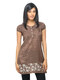

In [12]:
# display a product image
images[900]

In [13]:
# convert metadata into a pandas dataframe
metadata = metadata.to_pandas()
metadata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


We need both sparse and dense vectors to perform hybrid search. We will use all the metadata fields except for the `id` and `year` to create sparse vectors and the product images to create dense vectors.

## Sparse Vectors

To create the sparse vectors we'll use BM25. We import the BM25 function from the [`pinecone-text` library](https://github.com/pinecone-io/pinecone-text).

In [14]:
from pinecone_text.sparse import BM25Encoder

bm25 = BM25Encoder()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The tokenization will look something like this:

In [15]:
"Turtle Check Men Navy Blue Shirt".lower().split()

['turtle', 'check', 'men', 'navy', 'blue', 'shirt']

BM25 requires training on a representative portion of the dataset. We do this like so:

In [16]:
bm25.fit(metadata['productDisplayName'])

  0%|          | 0/44072 [00:00<?, ?it/s]

Let's create a test sparse vector using a `productDisplayName`.

In [17]:
metadata['productDisplayName'][0]

'Turtle Check Men Navy Blue Shirt'

In [18]:
bm25.encode_queries(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.3276687848622804,
  0.19377339510596148,
  0.040475545164610806,
  0.1808640794607714,
  0.10791423980552016,
  0.1493039556008558]}

And for the stored docs, we only need the "IDF" part:

In [19]:
bm25.encode_documents(metadata['productDisplayName'][0])

{'indices': [23789636,
  1830646559,
  632192512,
  931643408,
  3905155331,
  3828986392],
 'values': [0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887,
  0.4449638258432887]}

## Dense Vectors

We will use the CLIP to generate dense vectors for product images. We can directly pass PIL images to CLIP as it can encode both images and texts. We can load CLIP like so:

In [20]:
from sentence_transformers import SentenceTransformer
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# load a CLIP model from huggingface
model = SentenceTransformer(
    'sentence-transformers/clip-ViT-B-32',
    device=device
)
model

.gitattributes:   0%|          | 0.00/690 [00:00<?, ?B/s]

0_CLIPModel/config.json:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

0_CLIPModel/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

0_CLIPModel/preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

0_CLIPModel/tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

SentenceTransformer(
  (0): CLIPModel()
)

In [21]:
dense_vec = model.encode([metadata['productDisplayName'][0]])
dense_vec.shape

(1, 512)

The model gives us a `512` dimensional dense vector.

## Upsert Documents

Now we can go ahead and generate sparse and dense vectors for the full dataset and upsert them along with the metadata to the new hybrid index. We can do that easily as follows:

In [22]:
from tqdm.auto import tqdm

batch_size = 200

for i in tqdm(range(0, len(fashion), batch_size)):
    # find end of batch
    i_end = min(i+batch_size, len(fashion))
    # extract metadata batch
    meta_batch = metadata.iloc[i:i_end]
    meta_dict = meta_batch.to_dict(orient="records")
    # concatinate all metadata field except for id and year to form a single string
    meta_batch = [" ".join(x) for x in meta_batch.loc[:, ~meta_batch.columns.isin(['id', 'year'])].values.tolist()]
    # extract image batch
    img_batch = images[i:i_end]
    # create sparse BM25 vectors
    sparse_embeds = bm25.encode_documents([text for text in meta_batch])
    # create dense vectors
    dense_embeds = model.encode(img_batch).tolist()
    # create unique IDs
    ids = [str(x) for x in range(i, i_end)]

    upserts = []
    # loop through the data and create dictionaries for uploading documents to pinecone index
    for _id, sparse, dense, meta in zip(ids, sparse_embeds, dense_embeds, meta_dict):
        upserts.append({
            'id': _id,
            'sparse_values': sparse,
            'values': dense,
            'metadata': meta
        })
    # upload the documents to the new hybrid index
    index.upsert(upserts)

# show index description after uploading the documents
index.describe_index_stats()

  0%|          | 0/221 [00:00<?, ?it/s]

{'dimension': 512,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 44072}},
 'total_vector_count': 44072}

## Querying

Now we can query the index, providing the sparse and dense vectors. We do this directly with an equal weighting between sparse and dense like so:

In [23]:
query = "dark blue french connection jeans for men"

# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()
# search
result = index.query(
    top_k=14,
    vector=dense,
    sparse_vector=sparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
imgs

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80>]

We return a list of PIL image objects, to view them we will define a function called `display_result`.

In [24]:
from IPython.core.display import HTML
from io import BytesIO
from base64 import b64encode

# function to display product images
def display_result(image_batch):
    figures = []
    for img in image_batch:
        b = BytesIO()
        img.save(b, format='png')
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="data:image/png;base64,{b64encode(b.getvalue()).decode('utf-8')}" style="width: 90px; height: 120px" >
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')

And now we can view them:


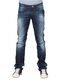
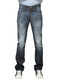
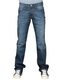
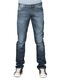
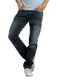
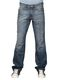
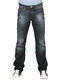
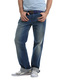
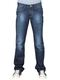
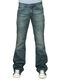
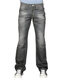
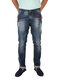
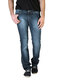
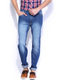

In [25]:
display_result(imgs)

It's possible to prioritize our search based on sparse vs. dense vector results. To do so, we scale the vectors, for this we'll use a function named `hybrid_scale`.

In [26]:
def hybrid_scale(dense, sparse, alpha: float):
    """Hybrid vector scaling using a convex combination

    alpha * dense + (1 - alpha) * sparse

    Args:
        dense: Array of floats representing
        sparse: a dict of `indices` and `values`
        alpha: float between 0 and 1 where 0 == sparse only
               and 1 == dense only
    """
    if alpha < 0 or alpha > 1:
        raise ValueError("Alpha must be between 0 and 1")
    # scale sparse and dense vectors to create hybrid search vecs
    hsparse = {
        'indices': sparse['indices'],
        'values':  [v * (1 - alpha) for v in sparse['values']]
    }
    hdense = [v * alpha for v in dense]
    return hdense, hsparse

First, we will do a pure sparse vector search by setting the alpha value as 0.


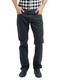
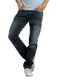
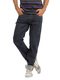
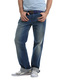
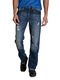
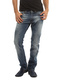
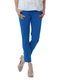
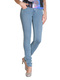
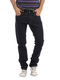
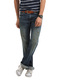
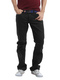
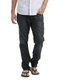
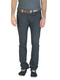
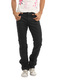

In [27]:
question = "dark blue french connection jeans for men"

# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

Let's take a look at the description of the result.

In [28]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Women Blue Jeans
French Connection Women Blue Jeans
French Connection Men Navy Blue Jeans
French Connection Men Blue paint Stained Regular Fit Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans
French Connection Men Black Jeans


We can observe that the keyword search returned French Connection jeans but failed to rank the men's French Connection jeans higher than a few of the women's. Now let's do a pure semantic image search by setting the alpha value to 1.


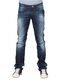
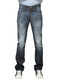
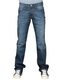
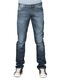
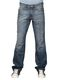
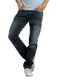
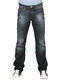
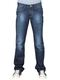
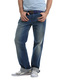
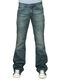
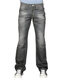
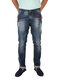
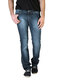
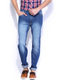

In [29]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [30]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Locomotive Men Radley Blue Jeans
Locomotive Men Race Blue Jeans
Locomotive Men Eero Blue Jeans
Locomotive Men Cam Blue Jeans
Locomotive Men Ian Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Cael Blue Jeans
Locomotive Men Lio Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Rafe Blue Jeans
Locomotive Men Barney Grey Jeans
Spykar Men Actif Fit Low Waist Blue Jeans
Wrangler Men Blue Skanders Jeans
John Players Men Blue Jeans


The semantic image search correctly returned blue jeans for men, but mostly failed to match the exact brand we are looking for — French Connection. Now let's set the alpha value to `0.05` to try a hybrid search that is slightly more dense than sparse search.


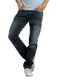
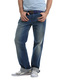
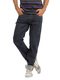
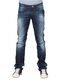
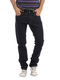
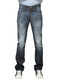
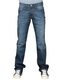
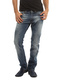
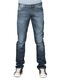
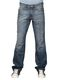
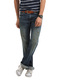
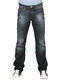
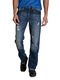
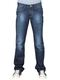

In [31]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [32]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

French Connection Men Blue Jeans
French Connection Men Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Radley Blue Jeans
French Connection Men Navy Blue Jeans
Locomotive Men Race Blue Jeans
Locomotive Men Eero Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Cam Blue Jeans
Locomotive Men Ian Blue Jeans
French Connection Men Blue paint Stained Regular Fit Jeans
Locomotive Men Cael Blue Jeans
French Connection Men Blue Jeans
Locomotive Men Lio Blue Jeans


By performing a mostly sparse search with some help from our image-based dense vectors, we get a strong number of French Connection jeans, that are for men, and visually are almost all aligned to blue jeans.

Let's try more queries.


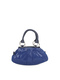
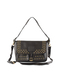
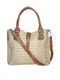
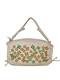
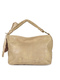
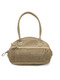
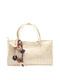
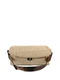
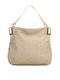
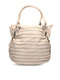
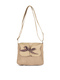
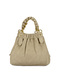
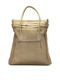
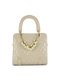

In [33]:
query = "small beige handbag for women"
# create sparse and dense vectors
sparse = bm25.encode_queries(query)
dense = model.encode(query).tolist()
# scale sparse and dense vectors - keyword search first
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

We get a lot of small handbags for women, but they're not beige. Let's use the image dense vectors to weigh the colors higher.


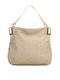
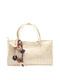
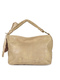
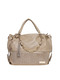
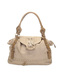
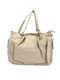
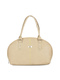
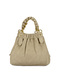
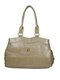
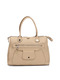
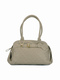
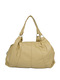
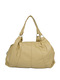
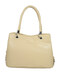

In [34]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.05)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

In [35]:
for x in result["matches"]:
    print(x["metadata"]['productDisplayName'])

Rocky S Women Beige Handbag
Kiara Women Beige Handbag
Baggit Women Beige Handbag
Lino Perros Women Beige Handbag
Kiara Women Beige Handbag
Kiara Women Beige Handbag
Murcia Women Beige Handbag
Rocia Women Beige Handbag
Murcia Women Hahk Beige Handbags
French Connection Women Beige Handbag
Baggit Women Beige Handbag
Murcia Women Emma Beige Handbags
Murcia Women Emma Beige Handbags
Murcia Women Hddcs Beige Handbags


Here we see better aligned handbags.


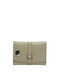
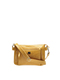
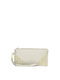
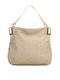
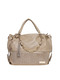
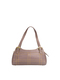
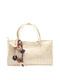
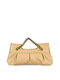
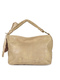
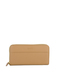
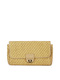
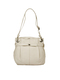
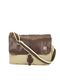
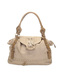

In [36]:
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=1)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

If we go too far with dense vectors, we start to see a few purses, rather than handbags.

Let's run some more interesting queries. This time we will use a **product image** to create our dense vector, we'll provide a text query as before that will be used to create the sparse vector, and then we'll select a specific color as per the metadata attached to each image, with [metadata filtering](https://docs.pinecone.io/docs/metadata-filtering).

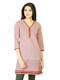

In [37]:
images[36254]


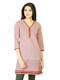
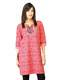
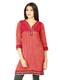
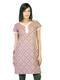
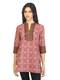
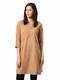
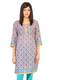
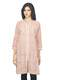
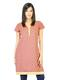
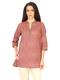
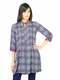
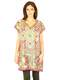
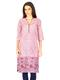
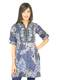

In [38]:
query = "soft purple topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

Our "purple" component isn't being considered strongly enough, let's add this to the metadata filtering:


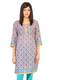
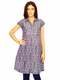
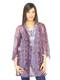
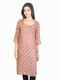
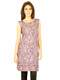
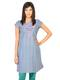
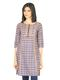
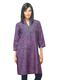
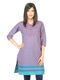
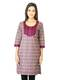
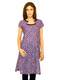
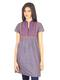
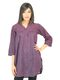
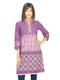

In [39]:
query = "soft purple topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36254]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.3)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Purple"}  # add to metadata filter
)
# used returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

Let's try with another image:

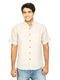

In [40]:
images[36256]


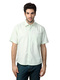
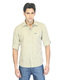
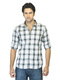
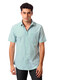
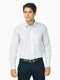
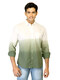
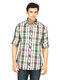
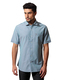
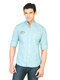
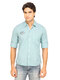
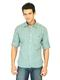
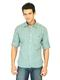
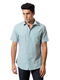
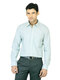

In [41]:
query = "soft green color topwear"
# create the sparse vector
sparse = bm25.encode_queries(query)
# now create the dense vector using the image
dense = model.encode(images[36256]).tolist()
# scale sparse and dense vectors
hdense, hsparse = hybrid_scale(dense, sparse, alpha=0.6)
# search
result = index.query(
    top_k=14,
    vector=hdense,
    sparse_vector=hsparse,
    include_metadata=True,
    filter={"baseColour": "Green"}  # add to metadata filter
)
# use returned product ids to get images
imgs = [images[int(r["id"])] for r in result["matches"]]
# display the images
display_result(imgs)

Here we did not specify the gender but the search results are accurate and we got products matching our query image and description.

# Delete the Index

If you're done with the index, we delete it to save resources.

In [ ]:
pinecone.delete_index(index_name)

---